# Gaussian fit of HC$_3$N and H$_2$CO

## File and package preparation

In [1]:
# import all important packages
import pyspeckit
import numpy as np
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk, opening
import os
# import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import aplpy
from B5setup import *
from scipy.interpolate import griddata

block_reduce was moved to the astropy.nddata.blocks module.  Please update your import statement.


In [2]:
# Where we estimate the line is
velinit = 9.0
velend = 11.3
starting_point = (107,166) #x, y
snratio = 5
velinitrms = 5.5
multicore = 40
minsizetrim = 100
verbosity = False

# File in K and in km/s
fitdir = 'gaussfit/'
imagefile = "B5-NOEMA+30m-H2CO-1-01-0-00_cut_K"  #"B5-NOEMA+30m-H3CN-10-9_cut_K"  # this comes from the CASA routine prepare_data.py
rmsfile = fitdir + imagefile + '_rms'
snrfile = fitdir + imagefile + '_snr'
tpeakfile = fitdir + imagefile + '_Tpeak'
maskfile = fitdir + imagefile + '_mask'
momentfile = fitdir + imagefile + '_moments.fits'

initguessfile = fitdir + imagefile + '_1G_guesses.fits'
newguessfile = fitdir + imagefile + '_1G_interp_guesses.fits'

fitfile =  fitdir + imagefile + '_1G_fitparams.fits'
fitfilefiltered = fitdir + imagefile + '_1G_fitparams_filtered.fits'
fitfile2 = fitdir + imagefile + '_1G_fitparams_2.fits'
fitfile2filtered = fitdir + imagefile + '_1G_fitparams_2_filtered.fits'

In [3]:
# load the cube and additional images

cube = pyspeckit.Cube(imagefile+'.fits')
header = cube.header

if not os.path.exists(rmsfile+'.fits'):
    rmsmap = cube.slice(velinitrms, velinit, unit='km/s').cube.std(axis=0)
    Tpeakmap = cube.slice(velinit, velend, unit='km/s').cube.max(axis=0)
    snrmap = Tpeakmap / rmsmap
    
    hdcube=cube.header.copy()
    key_remove=['NAXIS3','CRPIX3','CDELT3','CUNIT3','CTYPE3','CRVAL3','SPECSYS']
    for key_i in key_remove:
        hdcube.remove(key_i)
    hdcube['WCSAXES'] = 2
    hdcube['NAXIS'] = 2
    fits.writeto(rmsfile+'.fits', rmsmap, hdcube)
    print('Created RMS file')
    fits.writeto(tpeakfile+'.fits', Tpeakmap, hdcube)
    print('Created Tpeak file')
    hdcubesnr = hdcube.copy()
    hdcubesnr['BUNIT'] = ''
    fits.writeto(snrfile+'.fits', snrmap, hdcubesnr)
    print('Created SNR file')
    

else:
    rmsmap = fits.getdata(rmsfile+'.fits')
    Tpeakmap = fits.getdata(tpeakfile+'.fits')
    snrmap = fits.getdata(snrfile+'.fits')
    
    
if not os.path.exists(maskfile+'.fits'):
    key_remove=['NAXIS3','CRPIX3','CDELT3','CUNIT3','CTYPE3','CRVAL3','SPECSYS']
    hdcube=cube.header.copy()
    for key_i in key_remove:
        hdcube.remove(key_i)
    hdcube['WCSAXES'] = 2
    hdcube['NAXIS'] = 2
    hdcube['BUNIT'] = ''
    planemask = (snrmap > snratio)
    fits.writeto(maskfile+'_0.fits', planemask.astype(int), hdcube)
    # check the resulting mask map to see how much does the minimum size have to be and its connectivity
    # before applying this filter
    planemask = remove_small_objects(planemask, min_size=minsizetrim) # removes small islands of emission
    fits.writeto(maskfile+'_1.fits', planemask.astype(int), hdcube)
#     planemask = opening(planemask, disk(1))
    planemask = remove_small_holes(planemask, area_threshold=minsizetrim) # fills small holes inside the emission area
    fits.writeto(maskfile+'_2.fits', planemask.astype(int), hdcube)
    planemask = closing(planemask, disk(6)) # fills cracks
    fits.writeto(maskfile+'.fits', planemask.astype(int), hdcube)
    print('Created Mask file')
else:
    planemask = fits.getdata(maskfile+'.fits')
# initguesses = fits.getdata(initguessfile) #we have no initguesses for H2CO
print('Loaded initial files, ready to fit')

Loaded initial files, ready to fit


## Fitting

We did a first fit with moments as initial guesses and now we use the result of that first pass as initial guess.

In [5]:
# save the moments as initial guesses because it can take forever
if not os.path.exists(momentfile):
    cube.momenteach(vheight=False)
    fits.writeto(momentfile, cube.momentcube)
else:
    cube.momentcube = fits.getdata(momentfile)

initguesses = cube.momentcube
# initguesses = fits.getdata(initguessfile)[:3]
# initguesses[0][np.where(initguesses[0]<0)] = 0
# initguesses[1][np.where(initguesses[1]>velend)] = velend
# initguesses[1][np.where(initguesses[1]<velinit)] = velinit
# initguesses[2][np.where(initguesses[2]>velend-velinit)] = velend-velinit
# initguesses[0][np.where(np.isnan(initguesses[0]))] = 1
# initguesses[1][np.where(np.isnan(initguesses[1]))] = 10.2
# initguesses[2][np.where(np.isnan(initguesses[2]))] = 1

In [6]:
if not os.path.exists(fitfile):
    cube.fiteach(fittype='gaussian',
                 signal_cut=snratio,
                 guesses=initguesses,
                 errmap = rmsmap, 
                 maskmap = planemask,
                 limitedmin=[True, True, True],
                 limitedmax=[False, True, True],
                 minpars=[0, velinit, 0],
                 maxpars=[0, velend, velend-velinit],
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose=verbosity,
                 multicore=multicore)
    cube.write_fit(fitfile)
    fittedmodel = cube.get_modelcube()
    
else:
    cube.load_model_fit(fitfile, 3, fittype='gaussian')

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,40 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,40 [pyspeckit.spectrum.interactive]


NaN or infinite values encountered in parameter cube.


### Quality asessment

In [7]:
def filtersolutions(spc, rmsmap, snratio, velinit, velend, filter_negative=False, errorfrac=10, eps=1.e-6):
    """
    Replace the pixels in the fitted cube with np.nan where the fit is not
    good enough according to our criteria.

    The criteria that a pixel must have are:
    - The errors are not zero (less than eps)
    - The peak must not be negative in case filter_negatives is true
    - The error fraction is lower than errorfrac, not applied if errorfrac>=1
    - The moment 1 value must be within the range [velinit,velend]
    - The peak value must be larger than rms times rmslevel
    - The weighted velocity dispersion must be smaller than the absolute
    value of velend-velinit
    - If one parameter in a spectra is np.nan, all the spectra must be nan (sanity
    check)
    - All points must be within a region (part of the input)

    Args:
        variable (type): description

    Returns:
        type: description

    Raises:
        Exception: description

    """
    # we first create all the masks we need
    
    # all errors must be non zero
    # note that eps must be larger than the velocity dispersion
    zeromask = np.where(np.abs(spc.errcube[0])<eps, 1, 0)\
    + np.where(np.abs(spc.errcube[1])<eps, 1, 0)\
    + np.where(np.abs(spc.errcube[2])<eps, 1, 0)
    
    if errorfrac < 1.0:
        errormask = np.where(np.abs(spc.errcube[0]/spc.parcube[0]) > errorfrac, 1, 0)\
            + np.where(np.abs(spc.errcube[1]/spc.parcube[1]) > errorfrac, 1, 0)\
            + np.where(np.abs(spc.errcube[2]/spc.parcube[2]) > errorfrac, 1, 0)
    else:
        errormask = np.zeros(np.shape(zeromask), dtype=int)
        
    if filter_negative:
        negativemask = np.where(spc.parcube[0] < 0, 1, 0)\
        + np.where(spc.parcube[1] < 0, 1, 0) \
        + np.where(spc.parcube[2] < 0, 1, 0)
        
    else:
        negativemask = np.zeros(np.shape(zeromask), dtype=int)
    
    velocitymask = np.where(spc.parcube[1] < velinit, 1, 0) + \
        np.where(spc.parcube[1] > velend, 1, 0)
    snrmappeak = spc.parcube[0] / rmsmap
    peakmask = np.where(snrmappeak < snratio, 1, 0)
    
    nanmask = np.where(np.isnan(spc.parcube[0]), 1, 0)\
        + np.where(np.isnan(spc.parcube[1]), 1, 0)\
        + np.where(np.isnan(spc.parcube[2]), 1, 0)\
        + np.where(np.isnan(spc.errcube[0]), 1, 0)\
        + np.where(np.isnan(spc.errcube[1]), 1, 0)\
        + np.where(np.isnan(spc.errcube[2]), 1, 0)
    
    finalmask = zeromask + errormask + negativemask + velocitymask + peakmask + nanmask
        
    spc.parcube[np.where(np.repeat([finalmask], 3, axis=0))] = np.nan
    spc.errcube[np.where(np.repeat([finalmask], 3, axis=0))] = np.nan
    
    # eliminate isolated small islands of emission after the filter
    
    planemask = ~np.isnan(spc.parcube[0])
    planemask = remove_small_objects(planemask, min_size=minsizetrim)
    smallmask = np.ones(np.shape(planemask), dtype=int) - planemask
    spc.parcube[np.where(np.repeat([smallmask], 3, axis=0))] = np.nan
    spc.errcube[np.where(np.repeat([smallmask], 3, axis=0))] = np.nan
    return spc

In [8]:
# we apply the filter
if not os.path.exists(fitfilefiltered):
    cube = filtersolutions(cube, rmsmap, snratio, velinit, velend, filter_negative=True, errorfrac=0.5)
    cube.write_fit(fitfilefiltered)
    fittedmodel = cube.get_modelcube()
        
else:
    cube.load_model_fit(fitfilefiltered, 3, fittype='gaussian')
    fittedmodel = cube.get_modelcube()

NaN or infinite values encountered in parameter cube.


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,40 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,40 [pyspeckit.spectrum.interactive]


### Second fit: Interpolation of results

In [10]:
def interpolatesolutions(solfilein, npeaks, mask=None):
    '''
    The solfilein must be a .fits file that contains one parameter per 
    plane and then one parameter uncertainty per plane.
    The shape must be [nplane, yy, xx]
    The mask must be 2 dimensional
    '''
    solcube = fits.getdata(solfilein)[:3*npeaks]
    if np.any(np.isnan(solcube)):
        solcube[np.where(np.isnan(solcube))] = 0
    solcubeshape = np.shape(solcube)
    yy, xx = np.indices(solcubeshape[1:])
    filledcube = solcube.copy()
    headersolcube = fits.getheader(solfilein)

    for i, plane in enumerate(solcube):
        indexknown = np.where(plane<1e-5, False, True)
        filledcube[i][~indexknown] = griddata((xx[indexknown], yy[indexknown]),
                                                  plane[indexknown],
                                                  (xx[~indexknown], yy[~indexknown])
                                                 )
        if mask is not None:
            filledcube[i][np.where(mask==0)] = np.nan
    return filledcube, headersolcube


In [11]:
if not os.path.exists(newguessfile):
    print("Interpolating previous solutions.")
    newinitguess, headerguess = interpolatesolutions(fitfilefiltered, 1, mask=planemask)
    fits.writeto(newguessfile, newinitguess, headerguess)
    
else:
    print("Interpolation exists. Loading.")
    newinitguess = fits.getdata(newguessfile)

Interpolating previous solutions.


In [12]:
if not os.path.exists(fitfile2):
    print("Starting fit (S/N>3)")
    cube.fiteach(fittype='gaussian',
                 guesses=newinitguess,
                 errmap = rmsmap, 
                 maskmap = planemask,
                 limitedmin=[True, True, True],
                 limitedmax=[False, True, True],
                 minpars=[0, velinit, 0],
                 maxpars=[0, velend, velend-velinit],
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose=verbosity,
                 multicore=multicore)
    cube.write_fit(fitfile2)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit 2 exists. Loading")
    cube.load_model_fit(fitfile2, 3, fittype='gaussian')

Starting fit (S/N>3)
INFO: Fitting up to 40417 spectra [pyspeckit.cubes.SpectralCube]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,40 [pyspeckit.spectrum.interactive]


Mean of empty slice
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [13]:
# we apply the filter but this time dropping the snratio to 3
if not os.path.exists(fitfile2filtered):
    cube = filtersolutions(cube, rmsmap, 3, velinit, velend, filter_negative=True, errorfrac=0.5)
    cube.write_fit(fitfile2filtered)
    fittedmodel = cube.get_modelcube()
        
else:
    cube.load_model_fit(fitfile2filtered, 3, fittype='gaussian')
    fittedmodel = cube.get_modelcube()

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


There is a significant improvement from the first fit to the second in the southern tail, which is what we were looking for. Maybe it is worth to do a third pass, but for now, success!

## Plotting the results 

This is just to observe them quickly. The plots will be more polished in figures_B5.ipynb

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()


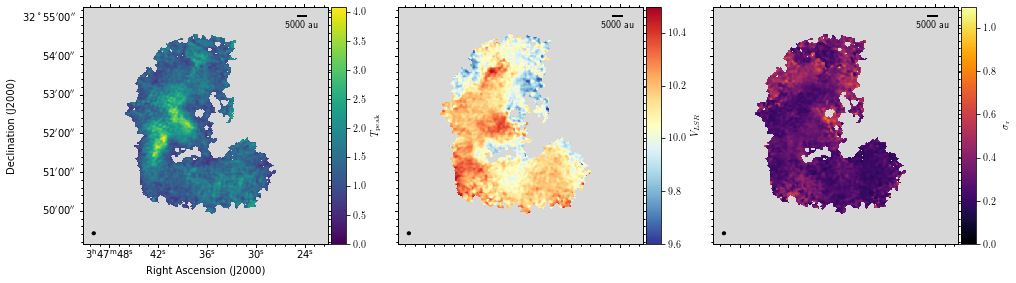

In [14]:
fig = plt.figure(1, figsize=(16,8))
figname = fitdir + imagefile + '_1G_fitparams_filtered_results.pdf'

paramscube = cube.parcube
errcube = cube.errcube
headerplot = fits.getheader(tpeakfile + '.fits')
stretch = 'linear'
vmin = [0, np.round(np.nanmin(paramscube[1]), 1), 0]
vmax = [np.round(np.nanmax(paramscube[0]), 1), np.round(np.nanmax(paramscube[1]), 1), np.round(np.nanmax(paramscube[2]), 1)]
cmap = ['viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$', r'$V_{LSR}$', r'$\sigma_{\mathrm{r}}$']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube[i], headerplot), fig, (1,3,i+1), stretch, \
                            vmin[i], vmax[i], cmap[i])
    ax0.colorbar.set_axis_label_text(quantities[i])
    if i:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()
        
fig.savefig(figname, bbox_inches='tight', dpi=300)

## Separating the components

In [15]:
hdparams=cube.header.copy()
key_remove=['NAXIS3','CRPIX3','CDELT3','CUNIT3','CTYPE3','CRVAL3','SPECSYS']
for key_i in key_remove:
    hdparams.remove(key_i)
hdparams['WCSAXES'] = 2
hdparams['NAXIS'] = 2
hdparams['BUNIT'] = ''
parameters = ['Tpeak', 'Vlsr', 'SigmaV']
for i in range(len(paramscube)):
    if not os.path.exists(fitfile2filtered[:len(fitfile2filtered)-5]+'_'+parameters[i]+'.fits'):
        fits.writeto(fitfile2filtered[:len(fitfile2filtered)-5]+'_'+parameters[i]+'.fits', paramscube[i], hdparams)



We can also plot with respect to the velocity for B5-IRS1 found in Pineda+15

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()


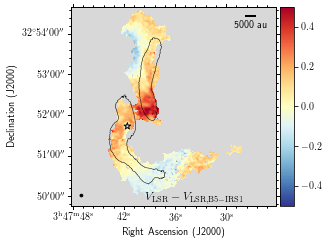

In [15]:
vlsr_irs1 = 10.2 #km/s
diffvlsr = paramscube[1] - vlsr_irs1
diffmin = -0.5
diffmax = 0.5
headerplot = fits.getheader(fitdir + imagefile + '_1G_fitparams_filtered_Vlsr.fits')
fig = plt.figure(1, figsize=(4,4))
figname = fitdir + imagefile + '_1G_fitparams_filtered_Vlsr_minus_irs1.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(diffvlsr, headerplot), 
                       fig, (1,1,1), 'linear', diffmin, 
                       diffmax, 'RdYlBu_r')
ax.add_label(0.6, 0.04, 
             r'$V_{\mathrm{LSR}} - V_{\mathrm{LSR}, \mathrm{B5-IRS1}}$', 
             relative=True, family='sans-serif', size=12)
ax.show_markers(ra_yso, dec_yso, s=50, marker='*', edgecolor='k', facecolor='None')
ax.show_contour('../B5_wide_multiple/data/B5_VLA_GBT_model_11_mom0.fits', colors='k', linewidths=0.5, levels=[0.1], zorder=34 )
# fig.savefig(figname, bbox_inches='tight')

# Two Gaussian fit towards B5-IRS1 for HC$_3$N

The spectra around IRS1 protostar (Per-emb-53) shows that it might be better fitted with two Gaussians instead of one. We create a subcube with only the vicinity of IRS1 and fit 2 Gaussians there

In [ ]:
from spectral_cube import SpectralCube # we need this to cut
x0, y0, x1, y1 = 83, 131, 133, 180

In [ ]:
# prepare the subcube
if not os.path.exists(imagefile+'_B5zoom.fits'):
    cube_SC = SpectralCube.read(imagefile+'.fits')
    subcube = cube_SC[:, y0:y1, x0:x1]
    # we save the new cube with its wcs information
    subcube.write(imagefile+'_B5zoom.fits')
    
subcube = pyspeckit.Cube(imagefile+'_B5zoom.fits')
subheader = subcube.header
subinitguesses = [2.1, 10.2, 0.2, 0.6, 9.2, 0.2] # we just use the same guesses for all
submask = fits.getdata(maskfile+'.fits')[y0:y1, x0:x1]
subrmsmap = fits.getdata(rmsfile+'.fits')[y0:y1, x0:x1]
subfitfile = fitdir + imagefile + '_B5zoom_2G_fitparams.fits'
subfitfilefiltered = fitdir + imagefile + '_B5zoom_2G_fitparams_filtered.fits'
substarting_point = (25, 24)

## Fitting
This is the first fit where we use fixed initial guesses for all pixels.

In [ ]:
if not os.path.exists(subfitfile):
    subcube.fiteach(fittype='gaussian',
                 guesses=subinitguesses,
                 signal_cut=snratio,
                 errmap = subrmsmap, 
                 maskmap = submask,
                 limitedmin=[True, True, True, True, True, True],
                 limitedmax=[False, True, True, False, True, True],
                 minpars=[0, velinit, 0, 0, velinit, 0],
                 maxpars=[0, velend, 0.5, 0, velend, 0.5],
                 use_neighbor_as_guess=True, 
                 start_from_point=substarting_point,
                 verbose_level=1,
                 multicore=multicore)
    subcube.write_fit(subfitfile)
    
else:
    subcube.load_model_fit(subfitfile, 3, npeaks=2, fittype='gaussian')

We checked manually if the fit is ok with check_fit_HC3N_interactive.py.

Now we use the obtained values as initial guesses.

In [ ]:
# fitting round 2
subinitguesses2 = subcube.parcube
subfitfile2 = fitdir + imagefile + '_B5zoom_2G_fitparams2.fits'
subfitfilefiltered2 = fitdir + imagefile + '_B5zoom_2G_fitparams2_filtered.fits'

if not os.path.exists(subfitfile2):
    subcube.fiteach(fittype='gaussian',
                 guesses=subinitguesses2,
                 signal_cut=snratio,
                 errmap = subrmsmap, 
                 maskmap = submask,
                 limitedmin=[True, True, True, True, True, True],
                 limitedmax=[False, True, True, False, True, True],
                 minpars=[0, velinit, 0, 0, velinit, 0],
                 maxpars=[0, velend, 0.5, 0, velend, 0.5],
                 use_neighbor_as_guess=True, 
                 start_from_point=substarting_point,
                 verbose_level=1,
                 multicore=multicore)
    subcube.write_fit(subfitfile2)
    
else:
    subcube.load_model_fit(subfitfile2, 3, npeaks=2, fittype='gaussian')

We checked the second run with the same code as before.

#### Quality asessment

In [ ]:
minsizetrim2 = 5
def filtersolutions2(spc, rmsmap, snratio, velinit, velend, filter_negative=False, checkseparation=False, maxwidth=2e9, errorfrac=10, eps=1.e-6):
    """
    Replace the pixels in the fitted cube with np.nan where the fit is not
    good enough according to our criteria.

    The criteria that a pixel must have are:
    - The errors are not zero (less than eps)
    - The peak must not be negative in case filter_negatives is true
    - The error fraction is lower than errorfrac, not applied if errorfrac>=1
    - The moment 1 value must be within the range [velinit,velend]
    - The peak value must be larger than rms times rmslevel
    - The weighted velocity dispersion must be smaller than the absolute
    value of velend-velinit
    - If one parameter in a spectra is np.nan, all the spectra must be nan (sanity
    check)
    - All points must be within a region (part of the input)

    Args:
        variable (type): description

    Returns:
        type: description

    Raises:
        Exception: description

    """
    # we first create all the masks we need
    
    # all errors must be non zero
    # note that eps must be larger than the velocity dispersion
    zeromask = np.where(np.abs(spc.errcube[0])<eps, 1, 0)\
    + np.where(np.abs(spc.errcube[1])<eps, 1, 0)\
    + np.where(np.abs(spc.errcube[2])<eps, 1, 0)\
    + np.where(np.abs(spc.errcube[3])<eps, 1, 0)\
    + np.where(np.abs(spc.errcube[4])<eps, 1, 0)\
    + np.where(np.abs(spc.errcube[5])<eps, 1, 0)
    
    if errorfrac < 10:
        errormask = np.where(np.abs(spc.errcube[0]/spc.parcube[0]) > errorfrac, 1, 0)\
            + np.where(np.abs(spc.errcube[1]/spc.parcube[1]) > errorfrac, 1, 0)\
            + np.where(np.abs(spc.errcube[2]/spc.parcube[2]) > errorfrac, 1, 0)\
            + np.where(np.abs(spc.errcube[3]/spc.parcube[3]) > errorfrac, 1, 0)\
            + np.where(np.abs(spc.errcube[4]/spc.parcube[4]) > errorfrac, 1, 0)\
            + np.where(np.abs(spc.errcube[5]/spc.parcube[5]) > errorfrac, 1, 0)
    else:
        errormask = np.zeros(np.shape(zeromask), dtype=int)
        
    if filter_negative:
        negativemask = np.where(spc.parcube[0] < 0, 1, 0)\
        + np.where(spc.parcube[1] < 0, 1, 0) \
        + np.where(spc.parcube[2] < 0, 1, 0) \
        + np.where(spc.parcube[3] < 0, 1, 0) \
        + np.where(spc.parcube[4] < 0, 1, 0) \
        + np.where(spc.parcube[5] < 0, 1, 0)
        
    else:
        negativemask = np.zeros(np.shape(zeromask), dtype=int)
    
    velocitymask = np.where(spc.parcube[1] < velinit, 1, 0) \
                    + np.where(spc.parcube[1] > velend, 1, 0)\
                    + np.where(spc.parcube[4] > velend, 1, 0)\
                    + np.where(spc.parcube[4] < velinit, 1, 0)
    
    snrmappeak = spc.parcube[0] / rmsmap
    peakmask = np.where(snrmappeak < snratio, 1, 0)
    snrmappeak2 = spc.parcube[3] / rmsmap
    peakmask2 = np.where(snrmappeak2 < snratio, 1, 0)
    
    nanmask = np.where(np.isnan(spc.parcube[0]), 1, 0)\
        + np.where(np.isnan(spc.parcube[1]), 1, 0)\
        + np.where(np.isnan(spc.parcube[2]), 1, 0)\
        + np.where(np.isnan(spc.parcube[3]), 1, 0)\
        + np.where(np.isnan(spc.parcube[4]), 1, 0)\
        + np.where(np.isnan(spc.parcube[5]), 1, 0)\
        + np.where(np.isnan(spc.errcube[0]), 1, 0)\
        + np.where(np.isnan(spc.errcube[1]), 1, 0)\
        + np.where(np.isnan(spc.errcube[2]), 1, 0)\
        + np.where(np.isnan(spc.errcube[3]), 1, 0)\
        + np.where(np.isnan(spc.errcube[4]), 1, 0)\
        + np.where(np.isnan(spc.errcube[5]), 1, 0)\
    
    if checkseparation:
        veldifmask = np.where(np.abs(spc.parcube[1]-spc.parcube[4])>spc.parcube[2]*3, 1, 0)
    else:
        veldifmask = np.zeros(np.shape(zeromask), dtype=int)
        
    if maxwidth<1e9:
        widthmask = np.where(spc.parcube[5]>maxwidth, 1, 0)
    else:
        widthmask = np.zeros(np.shape(zeromask), dtype=int)
    finalmask = zeromask + errormask + negativemask  + nanmask + velocitymask + veldifmask + widthmask #+ peakmask + peakmask2 
        
    spc.parcube[np.where(np.repeat([finalmask], 6, axis=0))] = np.nan
    spc.errcube[np.where(np.repeat([finalmask], 6, axis=0))] = np.nan
    
    # eliminate isolated small islands of emission after the filter
    
    planemask = ~np.isnan(spc.parcube[0])
    planemask = remove_small_objects(planemask, min_size=minsizetrim2)
    smallmask = np.ones(np.shape(planemask), dtype=int) - planemask
    spc.parcube[np.where(np.repeat([smallmask], 6, axis=0))] = np.nan
    spc.errcube[np.where(np.repeat([smallmask], 6, axis=0))] = np.nan
    return spc

In [ ]:
# we apply the filter
velinit2 = 8.9 #we are a bit more relaxed with the limits this time
velend2 = 10.3
if not os.path.exists(subfitfilefiltered2):
    subcube = filtersolutions2(subcube, subrmsmap, 1.5, velinit2, velend2, filter_negative=True, checkseparation=True, maxwidth=0.25, errorfrac=3)
    subcube.write_fit(subfitfilefiltered2)
    fittedmodel2 = subcube.get_modelcube()
        
else:
    subcube.load_model_fit(subfitfilefiltered2, 3, npeaks=2, fittype='gaussian')
    fittedmodel2 = subcube.get_modelcube()

# Decomposition

Here we take the 1 and 2 Gaussian fits and see what physical components are present

In [ ]:
# first we evaluate if we recover more information with the two Gaussian fit or not
def chi_square(yPred, yData, err):
    chi2 = np.sum((yPred-yData)**2/(err**2))
    return chi2

def chi_square_reduced(yPred, yData, err, k):
    chi2 = chi_square(yPred, yData, err)
    chi2red = chi2 / (len(yData)-k)
    return chi2red

def AIC(yPred, data, err, k):
    """
    Returns the Akaike information criterion (AIC) for a given function with a
    number of parameters k and a negative log-likelihood value given
    by func(data, params)
    """
    # ll = log_likelihood(yPred, data, err)
    # aic = 2 * k + 2 * ll
    chi2 = chi_square(yPred, data, err)
    aic = 2 * k + chi2 # we leave out the constant because it is the same for
    # both models
    return aic

def probaic(aicmin, aiclist):
    return np.exp((aicmin-aiclist)/2)

    

In [ ]:
fittedmodel1 = cube.get_modelcube()[:, y0:y1, x0:x1]
print(np.shape(fittedmodel1), np.shape(fittedmodel2))

In [ ]:
from astropy.modeling.functional_models import Gaussian1D
from astropy.wcs import WCS
# we define the variables we need
aic1map = np.zeros(np.shape(subinitguesses2[0])) * np.nan
aic2map = np.zeros(np.shape(subinitguesses2[0])) * np.nan

aic1mapfile = subfitfile[:len(subfitfile)-5] + '_aicmap1g.fits'
aic2mapfile = subfitfile[:len(subfitfile)-5] + '_aicmap2g.fits'

params1g = cube.parcube[:, y0:y1, x0:x1]
print(np.shape(params1g))
params2g = subcube.parcube
print(np.shape(params2g))
# This mask is 1 where the best fit is done with 2 Gaussians
mask2g = np.zeros(np.shape(subinitguesses2[0]), dtype=int)
mask2gfile = subfitfile[:len(subfitfile)-5] + '_2gmask.fits'
probtolerance = 0.05 # 95% or over probability that it actually does recover information better
flag_prob = np.zeros(np.shape(subinitguesses2[0]), dtype=int)
flagprobfile = subfitfile[:len(subfitfile)-5] + '_2gflagprob.fits'
problist = np.zeros(np.shape(subinitguesses2[0]), dtype=int) * np.nan
probfile = subfitfile[:len(subfitfile)-5] + '_2prob.fits'

chi1mapfile = subfitfile[:len(subfitfile)-5] + '_chi1g.fits'
chi2mapfile = subfitfile[:len(subfitfile)-5] + '_chi2g.fits'
chi1map = np.zeros(np.shape(subinitguesses2[0]))
chi2map = np.zeros(np.shape(subinitguesses2[0]))

In [ ]:
# we run the AIC test
for y in range(y1-y0):
    for x in range(x1-x0):
        velocity = subcube.get_spectrum(x, y).xarr.value
        spectrum = subcube.get_spectrum(x, y).data
        param1G = params1g[:, y, x]
        param2G = params2g[:, y, x]
        if np.all(np.isnan(param1G)) or np.all(np.isnan(param2G)):
            # If one of the fits failed, the comparison does not make sense
            continue
        ypred1g = np.flip(fittedmodel1[:, y, x])
        ypred2g = np.flip(fittedmodel2[:, y, x])
        aic1g = AIC(ypred1g, spectrum, subrmsmap[y, x], 3)
        aic1map[y,x] = aic1g
        aic2g = AIC(ypred2g, spectrum, subrmsmap[y, x], 6)
        aic2map[y,x] = aic2g
        chi1 = chi_square_reduced(ypred1g, spectrum, subrmsmap[y, x], 3)
        chi2 = chi_square_reduced(ypred2g, spectrum, subrmsmap[y, x], 6)
        chi1map[y, x] = chi1
        chi2map[y, x] = chi2
        # choose the minimum AIC
        if aic2g < aic1g: #that 2G are best
            mask2g[y, x] = 1
            # we evaluate the probability that the other model is as good for
            # minimizing information loss as the best one
            prob = np.exp((aic2g - aic1g)/2.)
            problist[y, x] = prob
            if prob > probtolerance:
                flag_prob[y,x] = 1
        else:
            prob = np.exp((aic1g - aic2g)/2.)
            problist[y, x] = prob
            if prob > probtolerance:
                flag_prob[y,x] = 1
            
aicheader = WCS(subcube.header).celestial.to_header()
if not os.path.exists(aic1mapfile): fits.writeto(aic1mapfile, aic1map, aicheader)
if not os.path.exists(aic2mapfile): fits.writeto(aic2mapfile, aic2map, aicheader)
if not os.path.exists(mask2gfile): fits.writeto(mask2gfile, mask2g, aicheader)
if not os.path.exists(flagprobfile): fits.writeto(flagprobfile, flag_prob, aicheader)
if not os.path.exists(probfile): fits.writeto(probfile, problist, aicheader)
if not os.path.exists(chi1mapfile): fits.writeto(chi1mapfile, chi1map, aicheader)
if not os.path.exists(chi2mapfile): fits.writeto(chi2mapfile, chi2map, aicheader)

In [ ]:
# This is a test spectra to see if we are calculating the AIC and arranging the
# spectra correctly in the loop
xtest, ytest = 22,20
velocity = subcube.get_spectrum(xtest, ytest).xarr.value
spectrum = subcube.get_spectrum(xtest, ytest).data
ypred1g = np.flip(fittedmodel1[:, ytest,xtest])
ypred2g = np.flip(fittedmodel2[:, ytest,xtest])
rms = subrmsmap[ytest,xtest]
chi1g = chi_square(ypred1g, spectrum, rms)
chi2g = chi_square(ypred2g, spectrum, rms)
aic1g = AIC(ypred1g, spectrum, rms, 3)
aic2g = AIC(ypred2g, spectrum, rms, 6)
print(chi1g, chi2g)
plt.plot(velocity, spectrum, 'k', drawstyle='steps-mid')
plt.plot(velocity, ypred1g, 'r')
plt.plot(velocity, ypred2g, 'g')


What we see in the maps is the following:
- There is a small zone towards the east of the blob where, according to the AIC criterion, the 1 Gaussian fits better than the 2 Gaussian fit
- The probability of the 2 Gaussian fit to recover as much information (or more) as the 1 Gaussian fit in the zone described above is much higher than 5% (its between 30 and 90% usually)
- Towards the west of the blob, 2 Gaussians fit better than 1 Gaussian according to the AIC criterion. The probability of 1 Gaussian recovering the same information there is less than 5%

A visual inspection of the fitted curves in the spectra convinces me that the 2 Gaussian fit is best, so in all the blob we will replace the previous 1 Gaussian fit with the strongest component of the 2 Gaussian fit. 

We will call this new map the hook.

### Creation of the hook

In [ ]:
# we take the cut map and replace the pixels which have a 2 Gaussian fit with the strongest
# component
index_2G = np.where(~np.isnan(params2g[0, :, :]))
params1g = cube.parcube[:, y0:y1, x0:x1]
errors1g = cube.errcube[:, y0:y1, x0:x1]
for y, x in zip(index_2G[0], index_2G[1]):
    params1g[:,y,x] = params2g[:3, y, x]
    errors1g[:,y,x] = subcube.errcube[:3, y, x]
    
        

In [ ]:
# we plot it quickly to see it and save the small cube
smallcubehookparamfile = subfitfile[:len(subfitfile)-5] + '_hookonlyparams.fits'
smallcubehookparams = np.concatenate([params1g, errors1g])
header = fits.getheader(subfitfilefiltered2)
header['NAXIS'] = 6
if not os.path.exists(smallcubehookparamfile):
    fits.writeto(smallcubehookparamfile, smallcubehookparams, header)

fig = plt.figure(figsize=(4,4))
velmin = -0.3
velmax = 0.3
aicheader['BMAJ'] = cube.header['BMAJ']
aicheader['BMIN'] = cube.header['BMIN']
aicheader['BPA'] = cube.header['BPA']
ax = plot_aplpy_subfig(fits.PrimaryHDU(params1g[1]-vlsr_irs1, aicheader),fig, (1,1,1), 'linear', velmin, velmax, 'RdYlBu_r')